In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import shap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import r2_score
from math import sqrt

# Set display options for Pandas tables so that results are legible.
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 1000
pd.options.display.float_format = '{:.5f}'.format

In [18]:
# Define project-wide functions

def create_explained_variance_df(pca: PCA): 
  """
  Function reused from exercise 8 in ML for Neuroscience class; code by Zvi Baratz. Used for summation of explained variance in PCA
  """
  results_dict = {
        "Individual Component": pca.explained_variance_ratio_,
        "Cumulative": np.cumsum(pca.explained_variance_ratio_),
  }
  index = range(1, pca.n_components_ + 1)
  df = pd.DataFrame(results_dict, index=index)
  df.index.name = "Component #"
  return df

def plot_explained_variance_ratio(
    pca: PCA,
    neighborhood_id
) -> tuple:
    """
    Plot explained variance by component number for a fitted PCA estimator - reused from exercise 8 in ML for Neuroscience class; code by Zvi Baratz.

    Parameters
    ----------
    pca : PCA
        Fitted PCA model
    neighborhood_number : int
        ID for the neighborhood
    Returns
    -------
    Tuple(Figure, Axes)
        Create figure and axes
    """

    # Create figure
    fig, ax = plt.subplots(figsize=(10,6))

    # Plot explained variance ratio by component
    x_range = range(1, pca.n_components_ + 1)
    ax.plot(x_range, pca.explained_variance_ratio_,label="Individual Component")

    # Plot cumulative explained variance
    cumulative_sum = np.cumsum(pca.explained_variance_ratio_)
    ax.plot(x_range, cumulative_sum,label="Cumulative")

    # Set menus
    customizations={"title": f"Neighborhood {neighborhood_id} - Explained Variance Ratio by Number of Principal Components",
    "xlabel": "Number of Principal Components",
    "ylabel": "Explained Variance Ratio"}
    ax.set(**customizations)

    # Add grid
    ax.grid()

    # Add legend
    fig.legend(bbox_to_anchor=(0.85, 0.7))

    # Fix x-axis tick labels to show integers
    ax.set_xticks(x_range)
    ax.set_xticklabels(x_range)

    return fig, ax

def oob_plotter(error_rates):
    """
    Plot OOB results for RF models based on OOB
    """
    horizontal_axis, vertical_axis = zip(*error_rates)
    plt.plot(horizontal_axis,vertical_axis,label="Random Forest with Max Features = n")
    plt.xlabel("Number of Estimators")
    plt.ylabel("OOB error rate")
    plt.legend()
    plt.show()

def scatter_plotter(x,y,labels:tuple,title:str):
   """
   Plot a scatterplot
   """
   fig = sns.scatterplot(x=x,y=y)
   fig.grid()
   fig.set_xlim(0,)
   fig.set_ylim(0,)
   fig.set(xlabel=labels[0],
           ylabel=labels[1],
           title=title)


def scatter_plotter_with_regline(x,y,labels:tuple,title:str):
   """
   Plot a scatterplot with a regression line
   """
   fig = sns.regplot(x=x,y=y)
   fig.grid()
   fig.set_xlim(0,)
   fig.set_ylim(0,)
   fig.set(xlabel=labels[0],
           ylabel=labels[1],
           title=title)

def write_results_to_csv(filename,contents):
    with open(f"{filename}.csv", "w", newline="") as fp:
        # Create a writer object
        writer = csv.DictWriter(fp, fieldnames=contents.keys())

        # Write the header row
        writer.writeheader()

        # Write the data rows
        writer.writerow(contents)

In [3]:
# The neighborhood object

class neighborhood:
    def __init__(self,train_set,test_set,neigh_id):
        self.train = train_set
        self.test = test_set
        self.id = neigh_id
    
    def __str__(self):
        return f"Neighborhood_{self.id}"
    
    def clean(self):
        """
        Load the data to appropriate variables, separated into train and test sets.
        """
        columns_to_drop = ["Neighb","Ped_St","Car_St","Bike_St","RootPed","SHAPE_Leng"]
        self.train = pd.read_csv(self.train, index_col=0)
        self.train.drop(columns=columns_to_drop,inplace=True)
        self.X_train = self.train.drop(columns=["LSegTot","SegToHo","PedToHo"])
        self.tot_train_y = self.train["SegToHo"]
        self.log_train_y = self.train["LSegTot"]
        self.test = pd.read_csv(self.test,index_col=0)
        self.test.drop(columns=columns_to_drop,inplace=True)
        self.X_test = self.test.drop(columns=["LSegTot","SegToHo","PedToHo"])
        self.tot_test_y = self.test["SegToHo"]
        self.log_test_y = self.test["LSegTot"]

    def create_standardized_variables(self):
        scaler = StandardScaler()
        col_names = self.X_train.columns
        self.X_train_standardized = pd.DataFrame(scaler.fit_transform(self.X_train),columns=col_names)
        self.X_test_standardized = pd.DataFrame(scaler.fit_transform(self.X_test),columns=col_names)

    def pca_producer(self,n_components):
        """
        Create PCA
        """
        self.pca = PCA(n_components=n_components)
        _ = self.pca.fit(self.X_train_standardized)
        self.pca_total_explained_variance = sum(self.pca.explained_variance_ratio_)
        self.pca_explained_variance_df = create_explained_variance_df(self.pca)
        self.X_train_pca = self.pca.transform(self.X_train_standardized)
        self.X_test_pca = self.pca.transform(self.X_test_standardized)
        self.principal_component_list = [f"PC{i}" for i in range(1,self.pca.components_.shape[0]+1)]
        self.pca_loadings = pd.DataFrame(self.pca.components_.T, columns=self.principal_component_list, index=self.X_test.columns)

    def Lasso_producer(self,alphas,log:bool,pca:bool):
        """
        Make LASSO models
        """
        lasso_param_grid = {"alpha": alphas}

        

        if log == False:
            y_train = self.tot_train_y
            y_test = self.tot_test_y
        elif log == True:
            y_train = self.log_train_y
            y_test = self.log_test_y
        
        if pca == False:
            X_train = self.X_train_standardized
            X_test = self.X_test_standardized
            col_names = self.X_train.columns
        elif pca == True:
            X_train = self.X_train_pca
            X_test = self.X_test_pca
            col_names = self.principal_component_list


        # Lasso gridsearch
        model = Lasso(max_iter=100000)
        grid_search = GridSearchCV(estimator=model,param_grid=lasso_param_grid)
        _ = grid_search.fit(X_train,y_train)
        coefficients_frame_tot = pd.DataFrame(grid_search.best_estimator_.coef_,index=col_names,columns=["value"])
        non_zero_coefficients_tot = coefficients_frame_tot[abs(coefficients_frame_tot["value"]) > 0]
        non_zero_coefficients_tot["abs_value"] = abs(non_zero_coefficients_tot["value"])
        non_zero_coefficients_tot.sort_values(by="abs_value", ascending=False)

        lasso_results = {
        "best_grid_search_params":grid_search.best_params_,
        "cleaned_best_model_coefficients":non_zero_coefficients_tot,
        "best_cv_score":grid_search.best_score_,
        "train_score":grid_search.score(X_train,y_train),
        "test_score":grid_search.score(X_test,y_test),
        "predicted_train":grid_search.predict(X_train),
        "predicted_test":grid_search.predict(X_test)
        }
        return model,grid_search,lasso_results

    def ridge_producer(self,alphas,log:bool,pca:bool):
        ridge_param_grid = {"alpha": alphas}


        if log == False:
            y_train = self.tot_train_y
            y_test = self.tot_test_y
        elif log == True:
            y_train = self.log_train_y
            y_test = self.log_test_y
        
        if pca == False:
            X_train = self.X_train_standardized
            X_test = self.X_test_standardized
            col_names = self.X_train.columns
        elif pca == True:
            X_train = self.X_train_pca
            X_test = self.X_test_pca
            col_names = self.principal_component_list
            
        
        model = Ridge()
        grid_search = GridSearchCV(estimator=model,param_grid=ridge_param_grid)
        _ = grid_search.fit(X_train,y_train)
        coefficients_frame_tot = pd.DataFrame(grid_search.best_estimator_.coef_,index=col_names,columns=["value"])
        non_zero_coefficients_tot = coefficients_frame_tot[abs(coefficients_frame_tot["value"]) > 0]
        non_zero_coefficients_tot["abs_value"] = abs(non_zero_coefficients_tot["value"])
        non_zero_coefficients_tot.sort_values(by="abs_value", ascending=False)

        ridge_results = {
        "best_grid_search_params":grid_search.best_params_,
        "cleaned_best_model_coefficients":non_zero_coefficients_tot,
        "best_cv_score":grid_search.best_score_,
        "train_score":grid_search.score(X_train,y_train),
        "test_score":grid_search.score(X_test,y_test),
        "predicted_train":grid_search.predict(X_train),
        "predicted_test":grid_search.predict(X_test)
        }
        
        return model,grid_search,ridge_results

    def random_forest_oob_producer(self,OOB_range,log:bool,pca:bool):
        """
        RF model based on OOB error reduction, using default settings.
        """
        if log == False:
            y_train = self.tot_train_y
            y_test = self.tot_test_y
        elif log == True:
            y_train = self.log_train_y
            y_test = self.log_test_y
        
        if pca == False:
            X_train = self.X_train
            X_test = self.X_test
        elif pca == True:
            X_train = self.X_train_pca
            X_test = self.X_test_pca

        rf = RandomForestRegressor(warm_start=True,oob_score=True,random_state=0)
        oob_error_rates = []
        for i in OOB_range:
            rf.set_params(n_estimators=i)
            rf.fit(X_train,y_train.values.ravel())
            oob_error = 1 - rf.oob_score_
            oob_error_rates.append((i,oob_error))
        dict_of_oob_errors = dict(oob_error_rates)
        best_n_estimators = min(dict_of_oob_errors,key=dict_of_oob_errors.get) # set the model to use the best number of trees
        rf.set_params(n_estimators=best_n_estimators,warm_start=False,random_state=0,oob_score=False)
        rf.fit(X_train,y_train.values.ravel())

        rf_results = {
        "oob_errors_for_graphing":oob_error_rates,
        "best n_estimators":best_n_estimators,
        "Train Score with best n_estimators":rf.score(X_train,y_train),
        "Test Score with best n_estimators":rf.score(X_test,y_test),
        "Predicted train":rf.predict(X_train),
        "Predicted test":rf.predict(X_test)
        }

        return rf,rf_results


    def random_forest_gridsearch_producer(self,param_grid,log:bool,pca:bool):
        """
        RF models using gridsearch to select hyperparameters.
        """
        if log == False:
            y_train = self.tot_train_y
            y_test = self.tot_test_y
        elif log == True:
            y_train = self.log_train_y
            y_test = self.log_test_y
        
        if pca == False:
            X_train = self.X_train
            X_test = self.X_test
        elif pca == True:
            X_train = self.X_train_pca
            X_test = self.X_test_pca
        

        rf_grid_model = RandomForestRegressor()
        rf_gridsearch = GridSearchCV(estimator=rf_grid_model,param_grid=param_grid)
        _ = rf_gridsearch.fit(X_train,y_train.values.ravel())

        results = {
        "best_grid_search_params":rf_gridsearch.best_params_,
        "best_cv_score":rf_gridsearch.best_score_,
        "train_score":rf_gridsearch.score(X_train,y_train),
        "test_score":rf_gridsearch.score(X_test,y_test),
        "predicted_train":rf_gridsearch.predict(X_train),
        "predicted_test":rf_gridsearch.predict(X_test)        
        
        }
        return rf_grid_model,rf_gridsearch,results


    
    def gradient_boost_producer(self,param_grid,log:bool,pca:bool):
        """
        Gradient boost models
        """
        if log == False:
            y_train = self.tot_train_y
            y_test = self.tot_test_y
        elif log == True:
            y_train = self.log_train_y
            y_test = self.log_test_y
        
        if pca == False:
            X_train = self.X_train
            X_test = self.X_test
        elif pca == True:
            X_train = self.X_train_pca
            X_test = self.X_test_pca

        gradient_boost = GradientBoostingRegressor()
        gb_grid_search = GridSearchCV(estimator=gradient_boost,param_grid=param_grid)
        _ = gb_grid_search.fit(X_train,y_train.values.ravel())
        
        results = {
        "best_grid_search_params":gb_grid_search.best_params_,
        "best_cv_score":gb_grid_search.best_score_,
        "train_score":gb_grid_search.score(X_train,y_train),
        "test_score":gb_grid_search.score(X_test,y_test),
        "predicted_train":gb_grid_search.predict(X_train),
        "predicted_test":gb_grid_search.predict(X_test)        
        }        

        return gradient_boost,gb_grid_search,results

    

        # loadings.sort_values(by=["PC1"], ascending=False)


In [4]:
# Initialize all neighborhoods and clean the data
prefix = "neigh_"
for i in range(1,6):
    globals()[prefix + str(i) + "_train"] ="Data_N" + str(i) + "_TRAIN_SET_CLEANED.csv"
    globals()[prefix + str(i) + "_test"] = "Data_N" + str(i) + "_TEST_SET_CLEANED.csv"
N1 = neighborhood(neigh_1_train,neigh_1_test,1)
N2 = neighborhood(neigh_2_train,neigh_2_test,2)
N3 = neighborhood(neigh_3_train,neigh_3_test,3)
N4 = neighborhood(neigh_4_train,neigh_4_test,4)
N5 = neighborhood(neigh_5_train,neigh_5_test,5)


for i in range(1,6):
    globals()["N" + str(i)].clean()

# Initialize full city dataset
city_train = "DATA_ALL_TRAIN_SET_CLEANED.csv"
city_test = "DATA_ALL_TEST_SET_CLEANED.csv"
City = neighborhood(city_train,city_test,"City")
City.clean()

neighborhoods = [N1,N2,N3,N4,N5,City]

In [32]:
# Fullsize PCA for all neighborhoods
for n in neighborhoods:
    n.create_standardized_variables()
    n.pca_producer(0.994)
    # N3.pca_loadings.sort_values(by=["PC5"], ascending=False)

             Individual Component  Cumulative
Component #                                  
1                         0.33582     0.33582
2                         0.17469     0.51052
3                         0.10134     0.61186
4                         0.07208     0.68393
5                         0.06382     0.74775
6                         0.04985     0.79760
7                         0.03316     0.83076
8                         0.02344     0.85420
9                         0.01962     0.87382
10                        0.01896     0.89278
11                        0.01603     0.90881
12                        0.01437     0.92318
13                        0.01185     0.93502
14                        0.01103     0.94606
15                        0.00915     0.95520
16                        0.00831     0.96351
17                        0.00699     0.97050
18                        0.00573     0.97623
19                        0.00398     0.98020
20                        0.00362 

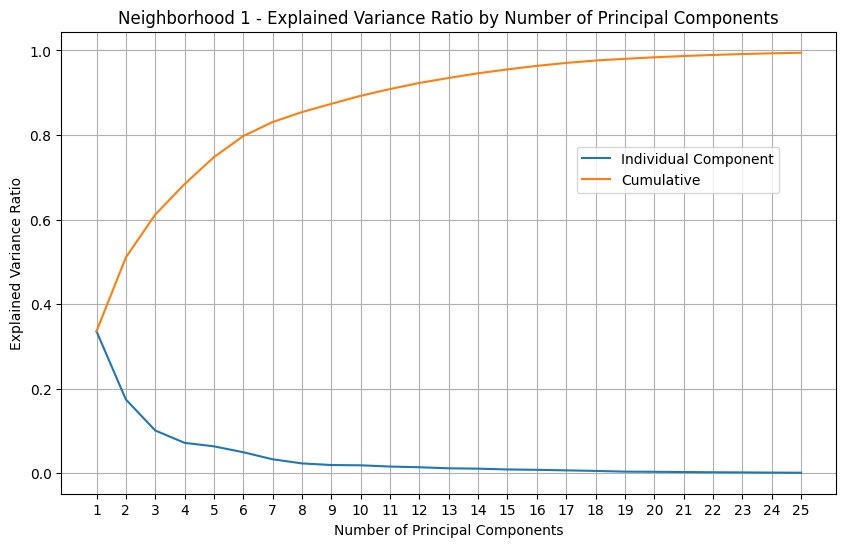

             Individual Component  Cumulative
Component #                                  
1                         0.34649     0.34649
2                         0.16990     0.51639
3                         0.08527     0.60166
4                         0.07391     0.67557
5                         0.05697     0.73254
6                         0.03903     0.77157
7                         0.03745     0.80902
8                         0.02590     0.83493
9                         0.02448     0.85941
10                        0.02104     0.88045
11                        0.01677     0.89722
12                        0.01557     0.91279
13                        0.01298     0.92577
14                        0.01128     0.93706
15                        0.00914     0.94620
16                        0.00840     0.95459
17                        0.00788     0.96247
18                        0.00643     0.96890
19                        0.00428     0.97318
20                        0.00314 

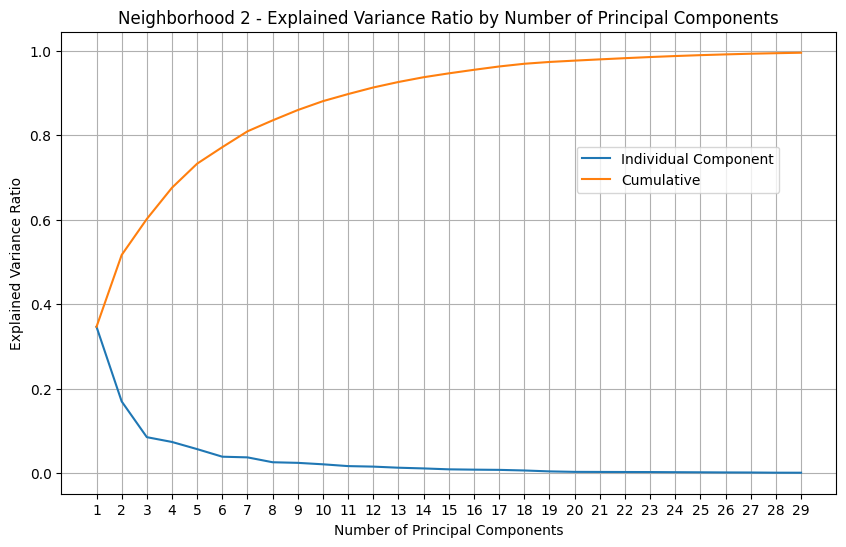

             Individual Component  Cumulative
Component #                                  
1                         0.34063     0.34063
2                         0.14357     0.48420
3                         0.13613     0.62033
4                         0.06518     0.68551
5                         0.05791     0.74342
6                         0.03959     0.78301
7                         0.03139     0.81440
8                         0.02476     0.83916
9                         0.01893     0.85809
10                        0.01786     0.87595
11                        0.01589     0.89184
12                        0.01501     0.90685
13                        0.01251     0.91936
14                        0.01113     0.93049
15                        0.01030     0.94079
16                        0.00758     0.94836
17                        0.00736     0.95573
18                        0.00620     0.96192
19                        0.00576     0.96769
20                        0.00492 

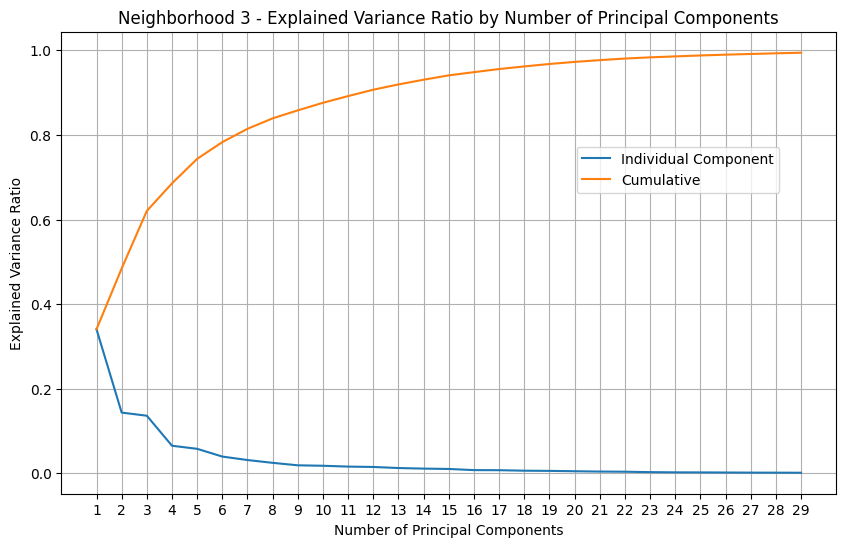

             Individual Component  Cumulative
Component #                                  
1                         0.36106     0.36106
2                         0.18081     0.54186
3                         0.10180     0.64366
4                         0.06183     0.70549
5                         0.04440     0.74989
6                         0.03939     0.78928
7                         0.03428     0.82356
8                         0.02728     0.85084
9                         0.02173     0.87257
10                        0.02025     0.89281
11                        0.01744     0.91025
12                        0.01454     0.92479
13                        0.01339     0.93818
14                        0.01031     0.94850
15                        0.00869     0.95719
16                        0.00778     0.96496
17                        0.00677     0.97173
18                        0.00459     0.97632
19                        0.00434     0.98067
20                        0.00345 

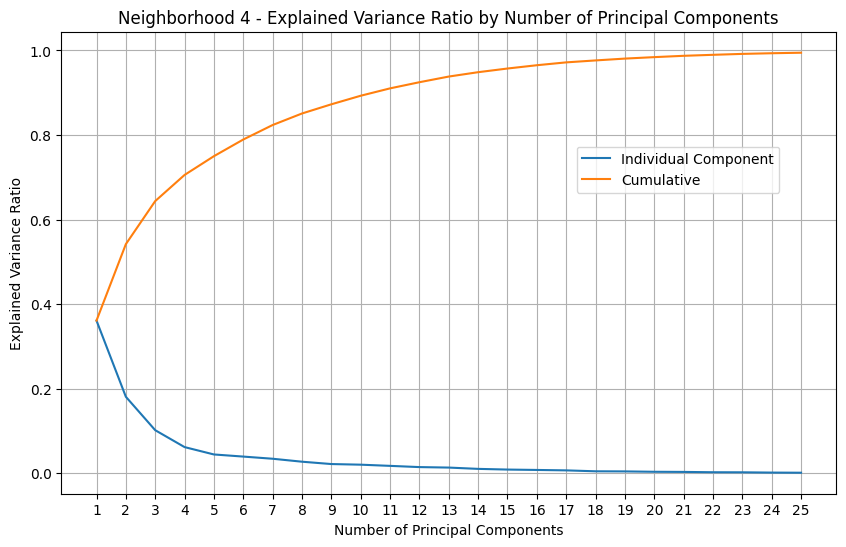

             Individual Component  Cumulative
Component #                                  
1                         0.35266     0.35266
2                         0.19791     0.55058
3                         0.13240     0.68298
4                         0.06843     0.75141
5                         0.04672     0.79813
6                         0.03598     0.83411
7                         0.03409     0.86820
8                         0.02691     0.89510
9                         0.02170     0.91680
10                        0.01651     0.93331
11                        0.01511     0.94842
12                        0.01218     0.96060
13                        0.01007     0.97068
14                        0.00859     0.97926
15                        0.00606     0.98532
16                        0.00442     0.98974
17                        0.00261     0.99235
18                        0.00229     0.99464


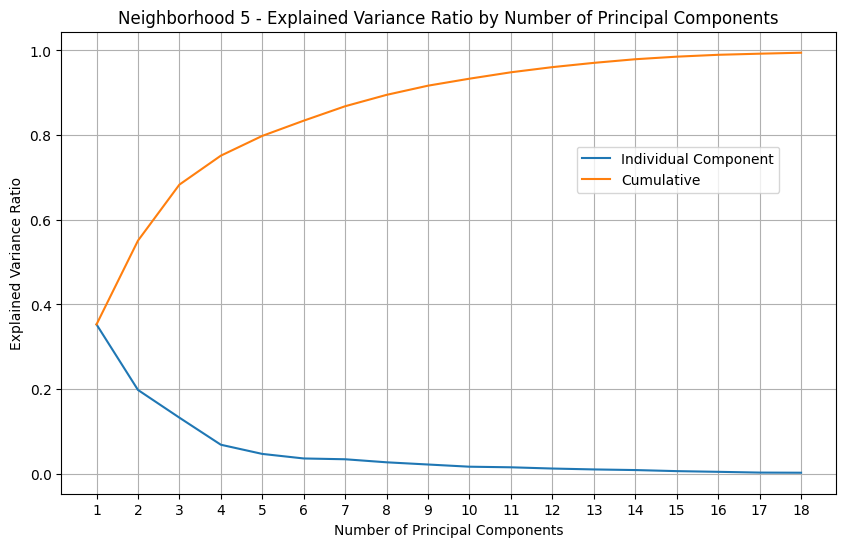

             Individual Component  Cumulative
Component #                                  
1                         0.30619     0.30619
2                         0.13696     0.44315
3                         0.10308     0.54623
4                         0.08285     0.62907
5                         0.04615     0.67522
6                         0.03993     0.71515
7                         0.03492     0.75007
8                         0.02856     0.77863
9                         0.02186     0.80049
10                        0.01968     0.82017
11                        0.01835     0.83853
12                        0.01568     0.85421
13                        0.01513     0.86934
14                        0.01353     0.88287
15                        0.01221     0.89508
16                        0.01097     0.90605
17                        0.00982     0.91587
18                        0.00819     0.92406
19                        0.00790     0.93195
20                        0.00686 

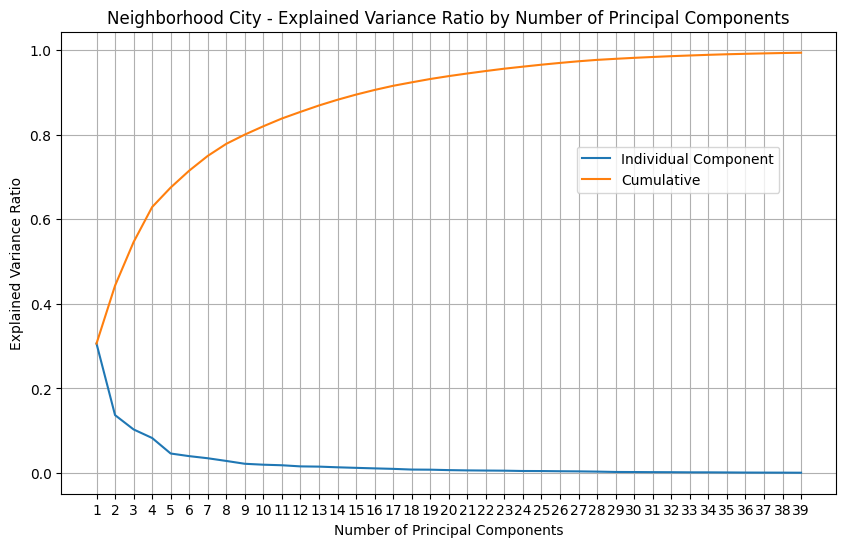

In [33]:
# Show PCA component contributions for each neighborhood
for n in neighborhoods:
    print(n.pca_explained_variance_df)
    plt.show(plot_explained_variance_ratio(n.pca,n.id))

In [5]:
# Reduce dimensionality for all neighborhoods so that PCs explain 90% of variance
for n in neighborhoods:
    n.create_standardized_variables()
    n.pca_producer(0.9)

             Individual Component  Cumulative
Component #                                  
1                         0.33582     0.33582
2                         0.17469     0.51052
3                         0.10134     0.61186
4                         0.07208     0.68393
5                         0.06382     0.74775
6                         0.04985     0.79760
7                         0.03316     0.83076
8                         0.02344     0.85420
9                         0.01962     0.87382
10                        0.01896     0.89278
11                        0.01603     0.90881


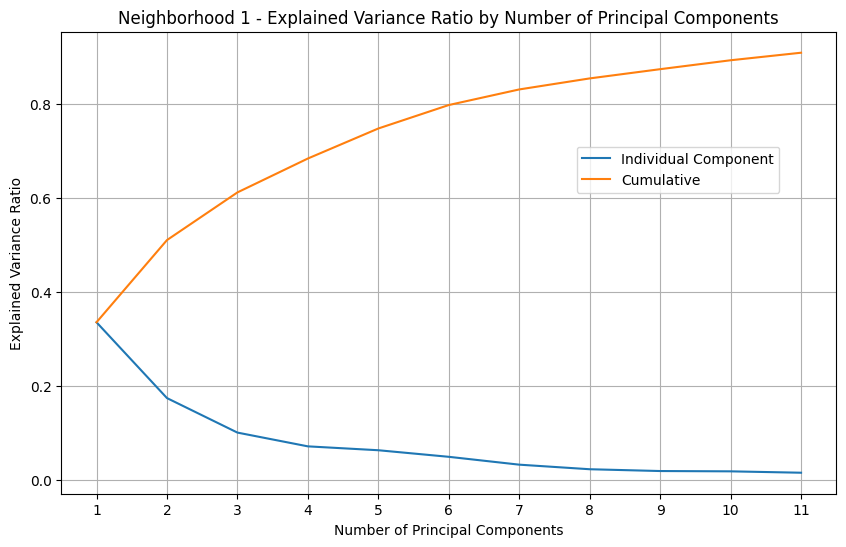

             Individual Component  Cumulative
Component #                                  
1                         0.34649     0.34649
2                         0.16990     0.51639
3                         0.08527     0.60166
4                         0.07391     0.67557
5                         0.05697     0.73254
6                         0.03903     0.77157
7                         0.03745     0.80902
8                         0.02590     0.83493
9                         0.02448     0.85941
10                        0.02104     0.88045
11                        0.01677     0.89722
12                        0.01557     0.91279


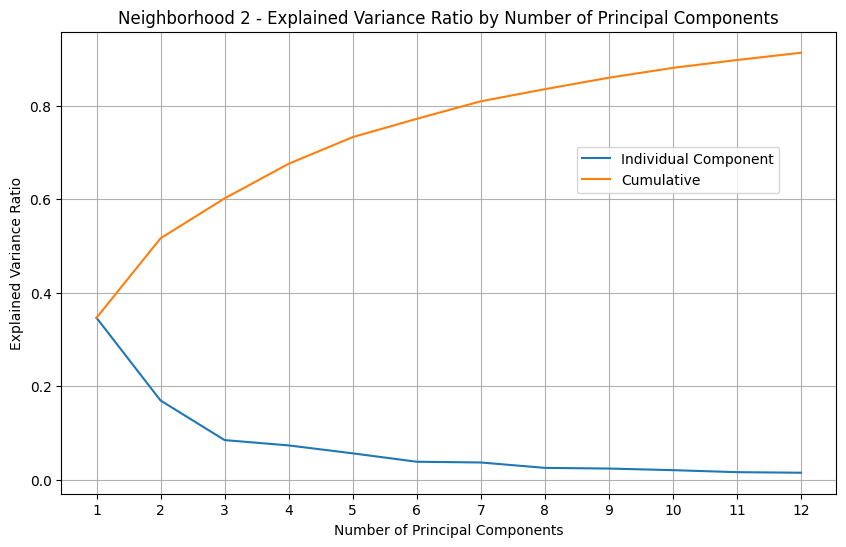

             Individual Component  Cumulative
Component #                                  
1                         0.34063     0.34063
2                         0.14357     0.48420
3                         0.13613     0.62033
4                         0.06518     0.68551
5                         0.05791     0.74342
6                         0.03959     0.78301
7                         0.03139     0.81440
8                         0.02476     0.83916
9                         0.01893     0.85809
10                        0.01786     0.87595
11                        0.01589     0.89184
12                        0.01501     0.90685


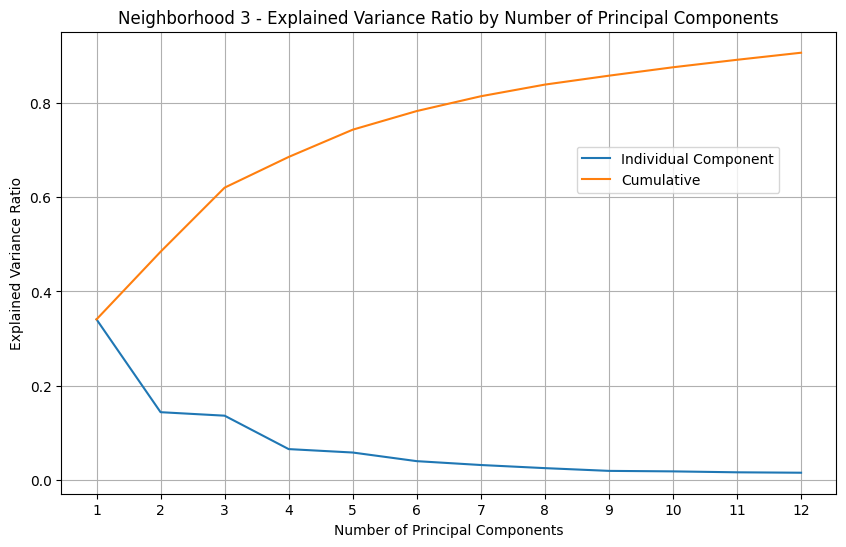

             Individual Component  Cumulative
Component #                                  
1                         0.36106     0.36106
2                         0.18081     0.54186
3                         0.10180     0.64366
4                         0.06183     0.70549
5                         0.04440     0.74989
6                         0.03939     0.78928
7                         0.03428     0.82356
8                         0.02728     0.85084
9                         0.02173     0.87257
10                        0.02025     0.89281
11                        0.01744     0.91025


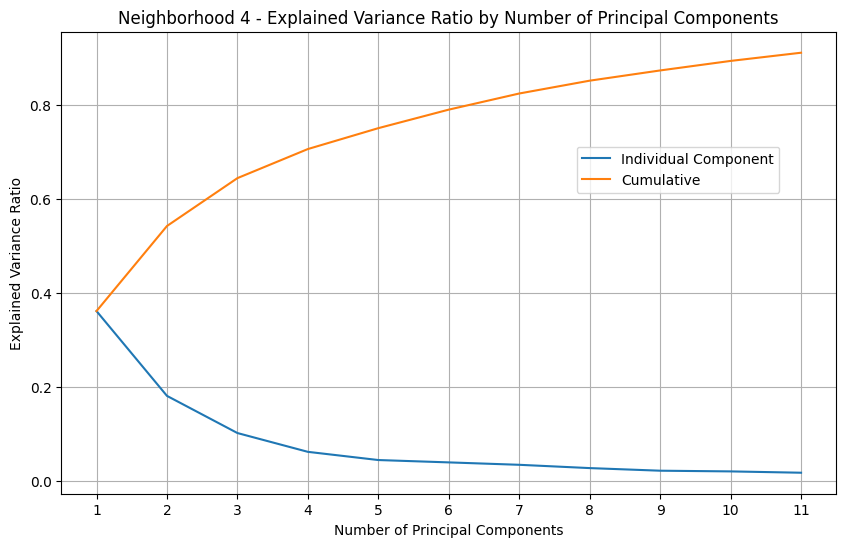

             Individual Component  Cumulative
Component #                                  
1                         0.35266     0.35266
2                         0.19791     0.55058
3                         0.13240     0.68298
4                         0.06843     0.75141
5                         0.04672     0.79813
6                         0.03598     0.83411
7                         0.03409     0.86820
8                         0.02691     0.89510
9                         0.02170     0.91680


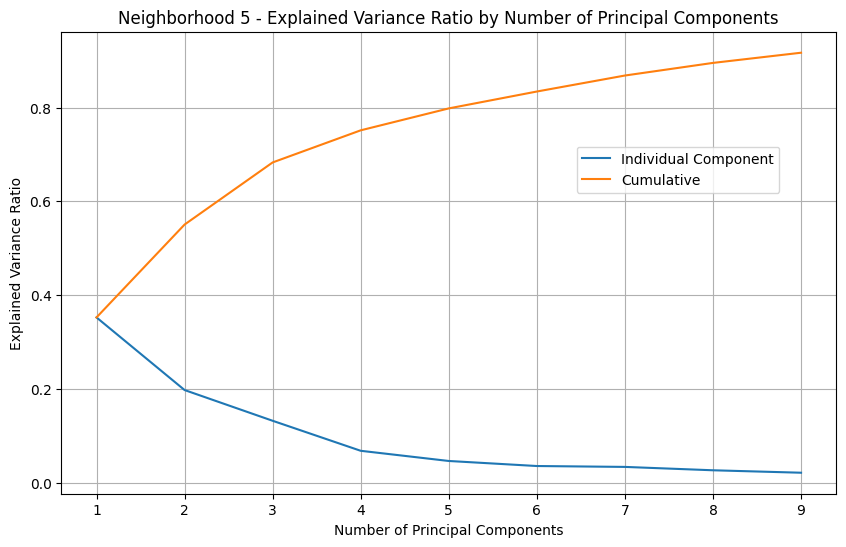

             Individual Component  Cumulative
Component #                                  
1                         0.30619     0.30619
2                         0.13696     0.44315
3                         0.10308     0.54623
4                         0.08285     0.62907
5                         0.04615     0.67522
6                         0.03993     0.71515
7                         0.03492     0.75007
8                         0.02856     0.77863
9                         0.02186     0.80049
10                        0.01968     0.82017
11                        0.01835     0.83853
12                        0.01568     0.85421
13                        0.01513     0.86934
14                        0.01353     0.88287
15                        0.01221     0.89508
16                        0.01097     0.90605


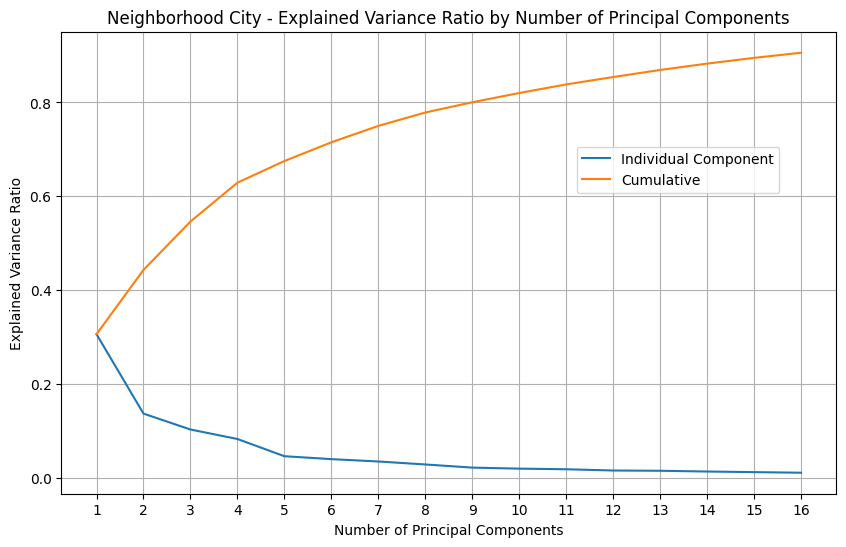

In [35]:
# Show truncated component contributions for each neighborhood
for n in neighborhoods:
    print(n.pca_explained_variance_df)
    plt.show(plot_explained_variance_ratio(n.pca,n.id))

In [48]:
# Show and save PC loadings tables
for n in neighborhoods:
    n.pca_loadings.sort_values(by=["PC1"], ascending=False).to_csv(f"Loadings_n_{n.id}.csv") 
    print(f"Loadings for Neighborhod{n.id}\n",n.pca_loadings.sort_values(by=["PC1"], ascending=False))

Loadings for Neighborhod1
                 PC1      PC2      PC3      PC4      PC5      PC6      PC7  \
A_Ch_R4500  0.17091 -0.03839 -0.00438 -0.08627 -0.01883  0.07430  0.08636   
A_Ch_R4000  0.17023 -0.03999 -0.00993 -0.08996 -0.01676  0.07129  0.09195   
A_Ch_R5000  0.16975 -0.03941 -0.00007 -0.08849 -0.01973  0.07648  0.07868   
A_Ch_R3500  0.16958 -0.04130 -0.01320 -0.09757  0.00093  0.06257  0.10029   
A_Ch_R1500  0.16703  0.00688 -0.02585 -0.06938  0.02150  0.08244  0.19680   
A_Ch_R3000  0.16568 -0.04888 -0.01036 -0.11822  0.04494  0.04092  0.11409   
A_Ch_R2000  0.16524 -0.03723 -0.01226 -0.11021  0.06039  0.05182  0.16719   
A_Ch_R1250  0.16282  0.04327 -0.04084 -0.03309  0.00849  0.09204  0.18313   
M_CH_R3500  0.16173  0.01332 -0.06919 -0.12893 -0.10345  0.07951 -0.10588   
M_CH_R4000  0.16000  0.00997 -0.06434 -0.11925 -0.11864  0.09567 -0.10721   
A_Ch_R2500  0.16000 -0.05558 -0.00707 -0.13176  0.08137  0.02715  0.13226   
M_CH_R3000  0.15988  0.01916 -0.07686 -0.14688 -0

In [ ]:
# Lasso Gridsearch for all neighborhoods

alphas = np.linspace(0.01, 100, 1000)
for n in neighborhoods:
    n.create_standardized_variables()
    n.lasso_tot,n.lasso_gridsearch_tot,n.lasso_results_tot = n.Lasso_producer(alphas,log=False,pca=False)
    n.lasso_log,n.lasso_gridsearch_log,n.lasso_results_log = n.Lasso_producer(alphas,log=True,pca=False)
    n.lasso_tot_pca,n.lasso_gridsearch_tot_pca,n.lasso_results_tot_pca = n.Lasso_producer(alphas,log=False,pca=True)
    n.lasso_log_pca,n.lasso_gridsearch_log_pca,n.lasso_results_log_pca = n.Lasso_producer(alphas,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_lasso_tot",n.lasso_results_tot)
    write_results_to_csv(f"neighborhood_{n.id}_lasso_log",n.lasso_results_log)
    write_results_to_csv(f"neighborhood_{n.id}_lasso_tot_pca",n.lasso_results_tot_pca)
    write_results_to_csv(f"neighborhood_{n.id}_lasso_log_pca",n.lasso_results_log_pca)


In [ ]:
# Ridge regression for all neighborhoods
alphas = np.linspace(0.01, 100, 1000)
for n in neighborhoods:
    n.ridge_tot,n.ridge_gridsearch_tot,n.ridge_results_tot = n.ridge_producer(alphas,log=False,pca=False)
    n.ridge_log,n.ridge_gridsearch_log,n.ridge_results_log = n.ridge_producer(alphas,log=True,pca=False)
    n.ridge_tot_pca,n.ridge_gridsearch_tot_pca,n.ridge_results_tot_pca = n.ridge_producer(alphas,log=False,pca=True)
    n.ridge_log_pca,n.ridge_gridsearch_log_pca,n.ridge_results_log_pca = n.ridge_producer(alphas,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_tot",n.ridge_results_tot)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_log",n.ridge_results_log)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_tot_pca",n.ridge_results_tot_pca)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_log_pca",n.ridge_results_log_pca)

In [ ]:
# OOB Randomforest for all neighborhoods

RF_range = range(50,2001,50)

for n in neighborhoods:
    n.rf_OOB_tot,n.rf_OOB_results_tot = n.random_forest_oob_producer(RF_range,log=False,pca=False)
    n.rf_OOB_log,n.rf_OOB_results_log = n.random_forest_oob_producer(RF_range,log=True,pca=False)
    n.rf_OOB_tot_pca,n.rf_OOB_results_tot_pca = n.random_forest_oob_producer(RF_range,log=False,pca=True)
    n.rf_OOB_log_pca,n.rf_OOB_results_log_pca = n.random_forest_oob_producer(RF_range,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_rf_OOB_tot",n.rf_OOB_results_tot)
    write_results_to_csv(f"neighborhood_{n.id}_rf_OOB_log",n.rf_OOB_results_log)
    write_results_to_csv(f"neighborhood_{n.id}_rf_OOB_tot_pca",n.rf_OOB_results_tot_pca)
    write_results_to_csv(f"neighborhood_{n.id}_rf_OOB_log_pca",n.rf_OOB_results_log_pca)

In [ ]:
# Gradient Boost for all neighborhoods

N_trees = range(1, 301, 15) # number of trees in GB
max_depth = range(1, 5) # number of splits per tree in GB
learning_rate = np.linspace(0.03,0.5,10) # shrinkage parameter in GB
gb_param_grid = {"learning_rate": learning_rate, "n_estimators": N_trees, "max_depth": max_depth}

for n in neighborhoods:
    n.GB_tot,n.GB_gridsearch_tot,n.GB_results_tot = n.gradient_boost_producer(param_grid=gb_param_grid,log=False,pca=False)
    n.GB_log,n.GB_gridsearch_log,n.GB_results_log = n.gradient_boost_producer(param_grid=gb_param_grid,log=True,pca=False)
    n.GB_tot_pca,n.GB_gridsearch_tot_pca,n.GB_results_tot_pca = n.gradient_boost_producer(param_grid=gb_param_grid,log=False,pca=True)
    n.GB_log_pca,n.GB_gridsearch_log_pca,n.GB_results_log_pca = n.gradient_boost_producer(param_grid=gb_param_grid,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_gradientboost_tot",n.GB_results_tot)
    write_results_to_csv(f"neighborhood_{n.id}_gradientboost_log",n.GB_results_log)
    write_results_to_csv(f"neighborhood_{n.id}_gradientboost_tot_pca",n.GB_results_tot_pca)
    write_results_to_csv(f"neighborhood_{n.id}_gradientboost_log_pca",n.GB_results_log_pca)    

In [ ]:
# RF gridsearch for all neighborhoods
n_estimators = range(50,1501,100)
max_features = [None, 'sqrt']
max_rf_depth = range(1,6)
rf_param_grid = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_rf_depth}
                

for n in neighborhoods:
    n.rf_gs_model_tot,n.rf_gs_gridsearch_tot,n.rf_gs_results_tot = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=False,pca=False)
    n.rf_gs_model_log,n.rf_gs_gridsearch_log,n.rf_gs_results_log = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=True,pca=False)
    n.rf_gs_model_tot_pca,n.rf_gs_gridsearch_tot_pca,n.rf_gs_results_tot_pca = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=False,pca=True)
    n.rf_gs_model_log_pca,n.rf_gs_gridsearch_log_pca,n.rf_gs_results_log_pca = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_tot",n.rf_gs_results_tot)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_log",n.rf_gs_results_log)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_tot_pca",n.rf_gs_results_tot_pca)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_log_pca",n.rf_gs_results_log_pca)    

From here on down, the code is reruns of models with retuned parameter grids, after checking the results of the first 120 (6 neighborhoods X 5 model types) models.

In [ ]:
# Improvements based on grid search session

# Ridge
alphas = np.linspace(1, 1000, 1000)
for n in neighborhoods:
    n.ridge_tot2,n.ridge_gridsearch_tot2,n.ridge_results_tot2 = n.ridge_producer(alphas,log=False,pca=False)
    n.ridge_log2,n.ridge_gridsearch_log2,n.ridge_results_log2 = n.ridge_producer(alphas,log=True,pca=False)
    n.ridge_tot_pca2,n.ridge_gridsearch_tot_pca2,n.ridge_results_tot_pca2 = n.ridge_producer(alphas,log=False,pca=True)
    n.ridge_log_pca2,n.ridge_gridsearch_log_pca2,n.ridge_results_log_pca2 = n.ridge_producer(alphas,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_tot2",n.ridge_results_tot2)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_log2",n.ridge_results_log2)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_tot_pca2",n.ridge_results_tot_pca2)
    write_results_to_csv(f"neighborhood_{n.id}_ridge_log_pca2",n.ridge_results_log_pca2)

In [ ]:
# Improvements based on grid search session

# RF OOB minimized
RF_range = range(1,151,5)

N4.rf_OOB_tot2,N4.rf_OOB_results_tot2 = N4.random_forest_oob_producer(RF_range,log=False,pca=False)
N4.rf_OOB_tot_pca2,N4.rf_OOB_results_tot_pca2 = N4.random_forest_oob_producer(RF_range,log=False,pca=True)
N4.rf_OOB_log_pca2,N4.rf_OOB_results_log_pca2 = N4.random_forest_oob_producer(RF_range,log=True,pca=True)
write_results_to_csv(f"neighborhood_{N4.id}_rf_OOB_tot2",N4.rf_OOB_results_tot2)
write_results_to_csv(f"neighborhood_{N4.id}_rf_OOB_tot_pca2",N4.rf_OOB_results_tot_pca2)
write_results_to_csv(f"neighborhood_{N4.id}_rf_OOB_log_pca2",N4.rf_OOB_results_log_pca2)

# RF OOB maximized

RF_range = range(1900,3001,100)
N1.rf_OOB_tot2,N1.rf_OOB_results_tot2 = N1.random_forest_oob_producer(RF_range,log=False,pca=False)
N2.rf_OOB_tot_pca2,N2.rf_OOB_results_tot_pca2 = N2.random_forest_oob_producer(RF_range,log=False,pca=True)

write_results_to_csv(f"neighborhood_{N1.id}_rf_OOB_tot2",N1.rf_OOB_results_tot2)
write_results_to_csv(f"neighborhood_{N2.id}_rf_OOB_tot_pca2",N2.rf_OOB_results_tot_pca2)



In [ ]:
# Improvements based on grid search session

# Gradient boost - maxed learning rate

N_trees = range(1, 301, 15) # number of trees in GB
max_depth = range(1, 5) # number of splits per tree in GB
learning_rate = np.linspace(0.3,5,10) # shrinkage parameter in GB
gb_param_grid = {"learning_rate": learning_rate, "n_estimators": N_trees, "max_depth": max_depth}

N1.GB_log2,N1.GB_gridsearch_log2,N1.GB_results_log2 = N1.gradient_boost_producer(param_grid=gb_param_grid,log=True,pca=False)
N4.GB_tot2,N4.GB_gridsearch_tot2,N4.GB_results_tot2 = N4.gradient_boost_producer(param_grid=gb_param_grid,log=False,pca=False)
write_results_to_csv(f"neighborhood_{N1.id}_gradientboost_log2",N1.GB_results_log2)
write_results_to_csv(f"neighborhood_{N4.id}_gradientboost_tot2",N4.GB_results_tot2)

# Gradient boost - minned learning rate

N_trees = range(1, 301, 15) # number of trees in GB
max_depth = range(1, 5) # number of splits per tree in GB
learning_rate = np.linspace(0.003,0.05,10) # shrinkage parameter in GB
gb_param_grid = {"learning_rate": learning_rate, "n_estimators": N_trees, "max_depth": max_depth}

N2.GB_log2,N2.GB_gridsearch_log2,N2.GB_results_log2 = N2.gradient_boost_producer(param_grid=gb_param_grid,log=True,pca=False)
City.GB_log2,City.GB_gridsearch_log2,City.GB_results_log2 = City.gradient_boost_producer(param_grid=gb_param_grid,log=True,pca=False)

write_results_to_csv(f"neighborhood_{N2.id}_gradientboost_log2",N2.GB_results_log2)
write_results_to_csv(f"neighborhood_{City.id}_gradientboost_log2",City.GB_results_log2)


In [ ]:
# Improvements based on grid search session

# RF gridsearch

n_estimators = range(50,1501,100)
max_features = [None, 'sqrt']
rf_param_grid = {'n_estimators': n_estimators,
                 'max_features': max_features,
                }
                

for n in neighborhoods:
    n.rf_gs_model_tot2,n.rf_gs_gridsearch_tot2,n.rf_gs_results_tot2 = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=False,pca=False)
    n.rf_gs_model_log2,n.rf_gs_gridsearch_log2,n.rf_gs_results_log2 = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=True,pca=False)
    n.rf_gs_model_tot_pca2,n.rf_gs_gridsearch_tot_pca2,n.rf_gs_results_tot_pca2 = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=False,pca=True)
    n.rf_gs_model_log_pca2,n.rf_gs_gridsearch_log_pca2,n.rf_gs_results_log_pca2 = n.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=True,pca=True)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_tot2",n.rf_gs_results_tot2)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_log2",n.rf_gs_results_log2)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_tot_pca2",n.rf_gs_results_tot_pca2)
    write_results_to_csv(f"neighborhood_{n.id}_rf_gridsearch_log_pca2",n.rf_gs_results_log_pca2)    

# RF grid search where n_estimators was minimized

n_estimators = range(10,151,5)
max_features = [None, 'sqrt']
max_rf_depth = range(1,6)
rf_param_grid = {'n_estimators': n_estimators,
                 'max_features': max_features,
                 'max_depth': max_rf_depth}

N3.rf_gs_model_tot3,N3.rf_gs_gridsearch_tot3,N3.rf_gs_results_tot3 = N3.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=False,pca=False)
N2.rf_gs_model_tot3,N2.rf_gs_gridsearch_tot3,N2.rf_gs_results_tot3 = N2.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=False,pca=False)
N1.rf_gs_model_log3,N1.rf_gs_gridsearch_log3,N1.rf_gs_results_log3 = N1.random_forest_gridsearch_producer(param_grid=rf_param_grid,log=True,pca=False)
write_results_to_csv(f"neighborhood_{N3.id}_rf_gridsearch_tot3",N3.rf_gs_results_tot3)
write_results_to_csv(f"neighborhood_{N2.id}_rf_gridsearch_tot3",N2.rf_gs_results_tot3)
write_results_to_csv(f"neighborhood_{N1.id}_rf_gridsearch_log3",N1.rf_gs_results_log3)



From here on down, code is various additional procedures

In [413]:
# Extract PCA matrices to work on in SPSS

for n in neighborhoods:
    PCA_train = pd.DataFrame(n.X_train_pca,index=n.X_train.index,columns=[f"PC{i}" for i in range(1,n.pca.components_.shape[0]+1)])
    PCA_train["SegToHo"] = n.tot_train_y
    PCA_train["LSegTot"] = n.log_train_y
    PCA_train["RootPed"] = n.tot_train_y**0.5
    PCA_test = pd.DataFrame(n.X_test_pca,index=n.X_test.index,columns=[f"PC{i}" for i in range(1,n.pca.components_.shape[0]+1)])
    PCA_test["SegToHo"] = n.tot_test_y
    PCA_test["LSegTot"] = n.log_test_y
    PCA_test["RootPed"] = n.tot_test_y**0.5
    PCA_train.to_csv(f"Neighborhood{n.id}_Train_PCA.csv")
    PCA_test.to_csv(f"Neighborhood{n.id}_Test_PCA.csv")

In [10]:
# Set up best models - rewrite this with a loop... still need to do N3, which is linear

# N1 - Do not touch
# n_estimators = [250]
# max_features = [None]
# max_rf_depth = [None]
# n1_optimal_rf_param_grid = {'n_estimators': n_estimators,
#                  'max_features': max_features,
#                  'max_depth': max_rf_depth}

# N1.best_rf,N1.best_rf_grid,N1.best_rf_results = N1.random_forest_gridsearch_producer(param_grid=n1_optimal_rf_param_grid,log=False,pca=True)
# N1.best_rf = N1.best_rf_grid.best_estimator_

# N2 - do not touch
# n_estimators = [150]
# max_features = [None]
# max_rf_depth = [4]
# n2_optimal_rf_param_grid = {'n_estimators': n_estimators,
#                  'max_features': max_features,
#                  'max_depth': max_rf_depth}

# N2.best_rf,N2.best_rf_grid,N2.best_rf_results = N2.random_forest_gridsearch_producer(param_grid=n2_optimal_rf_param_grid,log=True,pca=False)
# N2.best_rf = N2.best_rf_grid.best_estimator_

# N3
n3_optimal_alphas = [53]
N3.best_ridge, N3.best_ridge_gs, N3.best_ridge_results = N3.ridge_producer(n3_optimal_alphas,log=True,pca=False)
N3.best_ridge = N3.best_ridge_gs.best_estimator_

# N4 - do not touch
# N_trees = [31] # number of trees in GB
# max_depth = [4] # number of splits per tree in GB
# learning_rate = [0.5] # shrinkage parameter in GB
# n4_optimal_gb_param_grid = {"learning_rate": learning_rate, "n_estimators": N_trees, "max_depth": max_depth}

# N4.best_gb,N4.best_gb_gs,N4.best_gb_results = N4.gradient_boost_producer(param_grid=n4_optimal_gb_param_grid,log=False,pca=False)
# N4.best_gb = N4.best_gb_gs.best_estimator_

# City - Do not touch
N_trees = [16] # number of trees in GB
max_depth = [2] # number of splits per tree in GB
learning_rate = [0.134444444] # shrinkage parameter in GB
city_optimal_gb_param_grid = {"learning_rate": learning_rate, "n_estimators": N_trees, "max_depth": max_depth}

City.best_gb,City.best_gb_gs,City.best_gb_results = City.gradient_boost_producer(param_grid=city_optimal_gb_param_grid,log=False,pca=False)
City.best_gb = City.best_gb_gs.best_estimator_


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


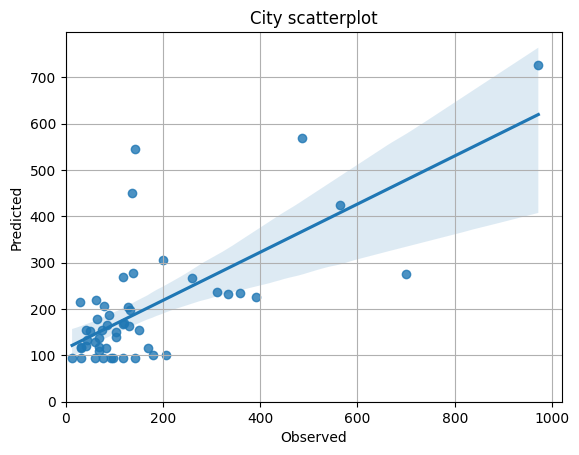

In [19]:
# Playing with scatterplots
# City.best_gb_results
# scatter_plotter_with_regline(City.tot_test_y,City.best_gb_results["predicted_test"],("Observed","Predicted"),"City scatterplot")

In [121]:
# Just checking scores

N3.best_ridge_results

{'best_grid_search_params': {'alpha': 53},
 'cleaned_best_model_coefficients':               value  abs_value
 COMSTO      0.09370    0.09370
 BANKOFF     0.00305    0.00305
 EDUCAT     -0.08222    0.08222
 PUBINST     0.02074    0.02074
 INDUST      0.02829    0.02829
 CULSPOR     0.03049    0.03049
 LandUs      0.08691    0.08691
 Park       -0.02544    0.02544
 POP_SEG    -0.07888    0.07888
 A_CONTVTY  -0.05749    0.05749
 CONTVTY    -0.01404    0.01404
 M_CH_RN    -0.05446    0.05446
 M_CH_R1000  0.03235    0.03235
 M_CH_R1250  0.03175    0.03175
 M_CH_R1500  0.02955    0.02955
 M_CH_R2000  0.02286    0.02286
 M_CH_R250  -0.01519    0.01519
 M_CH_R2500  0.01382    0.01382
 M_CH_R3000  0.01039    0.01039
 M_CH_R3500  0.00882    0.00882
 M_CH_R4000  0.00794    0.00794
 M_CH_R4500  0.00589    0.00589
 M_CH_R500  -0.00094    0.00094
 M_CH_R5000  0.00250    0.00250
 M_CH_R750   0.02000    0.02000
 M_MD_RN    -0.05635    0.05635
 M_MD_R1000  0.01597    0.01597
 M_MD_R1250  0.03266    0.

In [175]:
# SHAP explaining of good models

# for n in neighborhoods: # This whole thing is to be fixed, in reality done manually, anyway needs to be redone with a nicer more generalized approach
#     if n == N5:
#         continue
#     elif n == N3:
#         # Add code - linear explainer
#         continue # to be removed once linear explainer is here
#     elif n == N1:
#         n.X_whole_pca = np.concatenate([N1.X_train_pca,N1.X_test_pca])
#         n.shap_explainer = shap.TreeExplainer(n.best_rf)
#         n.shap_values = n.shap_explainer.shap_values(n.X_whole_pca)
#     elif n == N4 or n == City:
#         n.X_whole = pd.concat([n.X_train,n.X_test])
#         n.shap_explainer = shap.TreeExplainer(n.best_gb)
#         n.shap_values = n.shap_explainer.shap_values(n.X_whole)
#     elif n == N2:
#         n.X_whole = pd.concat([n.X_train,n.X_test])
#         n.shap_explainer = shap.TreeExplainer(n.best_rf)
#         n.shap_values = n.shap_explainer.shap_values(n.X_whole)

# N1
# N1.X_whole_pca = np.concatenate([N1.X_train_pca,N1.X_test_pca])
# N1.shap_explainer = shap.TreeExplainer(N1.best_rf)
# N1.shap_values = N1.shap_explainer.shap_values(N1.X_whole_pca)

# N2 - done
# N2.X_whole = pd.concat([N2.X_train,N2.X_test])
# N2.shap_explainer = shap.TreeExplainer(N2.best_rf)
# N2.shap_values = N2.shap_explainer.shap_values(N2.X_whole)

# N4 - done
# N4.X_whole = pd.concat([N4.X_train,N4.X_test])
# N4.shap_explainer = shap.TreeExplainer(N4.best_gb)
# N4.shap_values = N4.shap_explainer.shap_values(N4.X_whole)

# City - done
# City.X_whole = pd.concat([City.X_train,City.X_test])
# City.shap_explainer = shap.TreeExplainer(City.best_gb)
# City.shap_values = City.shap_explainer.shap_values(City.X_whole)


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


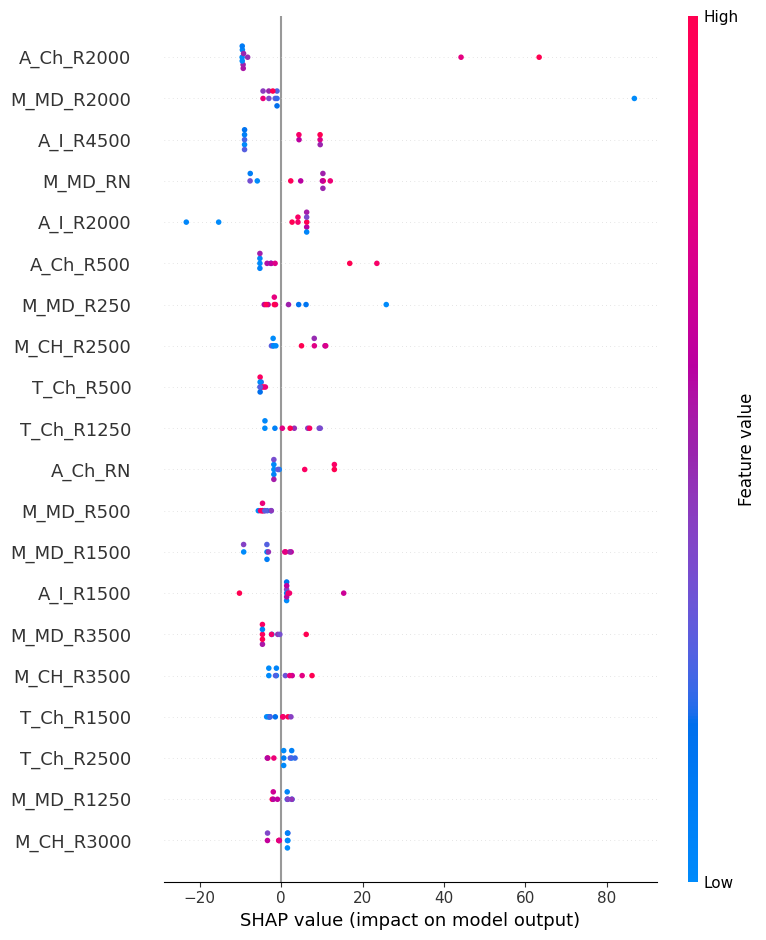

In [208]:
shap.initjs()

# shap.summary_plot(N1.shap_values,pd.DataFrame(N1.X_whole_pca,columns=N1.principal_component_list)) # N1 - all
# shap.summary_plot(N1.shap_values[36:,:],pd.DataFrame(N1.X_test_pca,columns=N1.principal_component_list)) # N1 - test only 
# shap.summary_plot(N2.shap_values,N2.X_whole) # N2 - all
# shap.summary_plot(N2.shap_values[44:,:],N2.X_test) # N2 - test only
# shap.summary_plot(N4.shap_values,N4.X_whole) # N4 - all
shap.summary_plot(N4.shap_values[39:,:],N4.X_test) # N4 - test only
# shap.summary_plot(City.shap_values,City.X_whole) # City - all
# shap.summary_plot(City.shap_values[196: , :],City.X_whole.iloc[196:, :]) # City - test only

# for n in neighborhoods: # to be finished later
#     if n == N5:
#         continue
#     elif n == N1:
#         shap.summary_plot(n.shap_values,pd.DataFrame(n.X_whole_pca,columns=n.principal_component_list))
#     else:
#         shap.summary_plot(n.shap_values,n.X_whole)
#         # shap.force_plot(City.shap_explainer.expected_value,City.shap_values,City.X_whole)


In [187]:
# N3 model coefficients export (for model interpertation)
N3.best_results_pretty = N3.best_ridge_results["cleaned_best_model_coefficients"].sort_values(by=["abs_value"], ascending=False).drop(index=["A_CONTVTY","CONTVTY"])
N3.best_results_pretty.to_csv("N3 pretty coefficients.csv")

In [207]:
N4.X_train.shape

(39, 82)

In [189]:
N3.best_ridge.intercept_

5.567910773584905

In [149]:
# individual forceplots

shap.force_plot(City.shap_explainer.expected_value,City.shap_values[215, :],City.X_whole.iloc[215,:]) # Bugrashov Pinsker
shap.force_plot(City.shap_explainer.expected_value,City.shap_values[221, :],City.X_whole.iloc[221,:]) # Ahad HaAm Sheinkin
shap.force_plot(City.shap_explainer.expected_value,City.shap_values[222, :],City.X_whole.iloc[222,:]) # Ahad HaAm Balfour


shap.force_plot(N4.shap_explainer.expected_value,N4.shap_values[39, :],N4.X_whole.iloc[39,:]) # Haganah
shap.force_plot(N4.shap_explainer.expected_value,N4.shap_values[45, :],N4.X_whole.iloc[45,:]) # LaGuardia

In [131]:
def logodds_to_prob(log_odds):
    odds = np.exp(log_odds)
    return odds / (1 + odds)

logodds_to_prob(126.18)

1.0

In [79]:
# r2_score(checking["LSegTot"],checking["predicted"])
# pd.Series(N1.best_rf_results["predicted_test"]).corr(pd.Series(N1.tot_test_y.values))**2
# pd.Series(N2.best_rf_results["predicted_test"]).corr(pd.Series(N2.log_test_y.values))**2
pd.Series(N4.best_gb_results["predicted_test"]).corr(pd.Series(N4.tot_test_y.values))**2
# pd.Series(City.best_gb_results["predicted_test"]).corr(pd.Series(City.tot_test_y.values))**2

0.7257050445094156

In [ ]:
######## Data Cleaning and preparation for all neighborhoods - IRRELEVANT ########

# columns_to_drop = ["Neighb","Ped_St","Car_St","Bike_St","RootPed","SHAPE_Leng"]
# prefix = "neigh_"

# for i in range(1,6):
#     globals()[prefix + str(i) + "_train"] = pd.read_csv("Data_N" + str(i) + "_TRAIN_SET_CLEANED.csv", index_col=0)
#     globals()[prefix + str(i) + "_train"].drop(columns=columns_to_drop,inplace=True)
#     globals()[prefix + str(i) + "_X_train"] = globals()[prefix + str(i) + "_train"].drop(columns=["LSegTot","SegToHo","PedToHo"])
#     globals()[prefix + str(i) + "_tot_target_train"] = globals()[prefix + str(i) + "_train"]["SegToHo"]
#     globals()[prefix + str(i) + "_log_target_train"] = globals()[prefix + str(i) + "_train"]["LSegTot"]

#     globals()[prefix + str(i) + "_test"] = pd.read_csv("Data_N" + str(i) + "_TEST_SET_CLEANED.csv", index_col=0)
#     globals()[prefix + str(i) + "_test"].drop(columns=columns_to_drop,inplace=True)
#     globals()[prefix + str(i) + "_X_test"] = globals()[prefix + str(i) + "_test"].drop(columns=["LSegTot","SegToHo","PedToHo"])
#     globals()[prefix + str(i) + "_tot_target_test"] = globals()[prefix + str(i) + "_test"]["SegToHo"]
#     globals()[prefix + str(i) + "_log_target_test"] = globals()[prefix + str(i) + "_test"]["LSegTot"]

In [ ]:
# ######## LASSO prep - turned this function into a method #######

# def Lasso_producer(X_train,X_test,y_train,y_test,alphas):
#     lasso_param_grid = {"alpha": alphas}
#     scaler = StandardScaler()

#     col_names = X_train.columns
#     X_train_standardized = pd.DataFrame(scaler.fit_transform(X_train),columns=col_names)
#     lasso_model= Lasso(max_iter=100000)
#     lasso_grid_search = GridSearchCV(estimator=lasso_model,param_grid=lasso_param_grid)
#     _ = lasso_grid_search.fit(X_train_standardized,y_train)
#     X_test_standardized = pd.DataFrame(scaler.fit_transform(X_test),columns=col_names)

#     coeffs = lasso_grid_search.best_params_
#     best_cv_score = lasso_grid_search.best_score_
#     train_score = lasso_grid_search.score(X_train_standardized,y_train)
#     test_score = lasso_grid_search.score(X_test_standardized,y_test)
#     return [coeffs,best_cv_score,train_score,test_score]